In [1]:
import pandas as pd
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import PyQt5
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace
from Bio import SeqIO
import re
from Bio import Phylo
from io import StringIO
from bisect import bisect_left
import numpy as np
from collections import Counter
tqdm.pandas()

In [3]:
# How many human DHS which are mapped on mouse, intersect with mouse DHS list?

file_path = '/net/seq/data2/projects/aabisheva/DHS_evolution/benchmark/hg38/cactus447way_reciprocal_mapping/intersection_2.txt'
human_dhs_mapped_on_mouse = pd.read_csv(file_path, sep="\t", header=None)

print(f"Number of '1's in the last column: {human_dhs_mapped_on_mouse[12].sum()}")

/tmp/ipykernel_42206/3270853242.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  human_dhs_mapped_on_mouse = pd.read_csv(file_path, sep="\t", header=None)


Number of '1's in the last column: 593567


In [4]:
# How many mouse DHS which are mapped on human, intersect with human DHS list?

file_path = '/net/seq/data2/projects/aabisheva/DHS_evolution/benchmark/hg38/cactus447way_reciprocal_mapping/intersection.txt'
mouse_dhs_mapped_on_human = pd.read_csv(file_path, sep="\t", header=None)

print(f"Number of '1's in the last column: {mouse_dhs_mapped_on_human[12].sum()}")


Number of '1's in the last column: 469145


In [5]:
new_column_names = {
    mouse_dhs_mapped_on_human.columns[0]: 'human_chr',
    mouse_dhs_mapped_on_human.columns[1]: 'human_start',
    mouse_dhs_mapped_on_human.columns[2]: 'human_end',
    mouse_dhs_mapped_on_human.columns[3]: 'mouse_dhs_id',
    mouse_dhs_mapped_on_human.columns[12]: 'intersected_or_not_with_human_dhs',
    mouse_dhs_mapped_on_human.columns[13]: 'intersected_human_dhs'
}
mouse_dhs_mapped_on_human.rename(columns=new_column_names, inplace=True)

mouse_dhs_mapped_on_human

,human_chr,human_start,human_end,mouse_dhs_id,4,5,6,7,8,9,10,11,intersected_or_not_with_human_dhs,intersected_human_dhs
0,KI270728.1,1194559,1194673,chunk1146_790_2,1000,+,1194559,1194673,"0,0,0",2,"24,21","0,93",0,NaN
1,KI270752.1,8529,8572,chunk1523_489_3,1000,+,8529,8572,"0,0,0",1,43,0,0,NaN
2,chr1,933615,933712,chunk4662_1122_1,1000,+,933615,933712,"0,0,0",6,"10,15,6,21,12,26","0,11,27,34,58,71",1,chunk0006_686_1;chunk0006_688_1
3,chr1,935089,935166,chunk4662_1120_1,1000,+,935089,935166,"0,0,0",3,"23,29,11","0,24,66",1,chunk0006_691_1;chunk0006_692_1
4,chr1,935555,935877,chunk4662_1117_1,1000,+,935555,935877,"0,0,0",2,"19,112","0,210",1,chunk0006_693_1;chunk0006_695_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608821,chrY,19576366,19576400,chunk6179_1946_1,1000,+,19576366,19576400,"0,0,0",1,34,0,0,NaN
608822,chrY,19773688,19773745,chunk5629_175_1,1000,+,19773688,19773745,"0,0,0",2,"32,24","0,33",0,NaN
608823,chrY,20957034,20957066,chunk1525_321_1,1000,+,20957034,20957066,"0,0,0",1,32,0,0,NaN
608824,chrY,26576592,26576629,chunk5807_104_1,1000,+,26576592,26576629,"0,0,0",1,37,0,0,NaN


In [6]:
new_column_names = {
    human_dhs_mapped_on_mouse.columns[0]: 'mouse_chr',
    human_dhs_mapped_on_mouse.columns[1]: 'mouse_start',
    human_dhs_mapped_on_mouse.columns[2]: 'mouse_end',
    human_dhs_mapped_on_mouse.columns[3]: 'human_dhs_id',
    human_dhs_mapped_on_mouse.columns[12]: 'intersected_or_not_with_mouse_dhs',
    human_dhs_mapped_on_mouse.columns[13]: 'intersected_mouse_dhs'
}
human_dhs_mapped_on_mouse.rename(columns=new_column_names, inplace=True)

human_dhs_mapped_on_mouse

,mouse_chr,mouse_start,mouse_end,human_dhs_id,4,5,6,7,8,9,10,11,intersected_or_not_with_mouse_dhs,intersected_mouse_dhs
0,GL455991.1,151420,151535,chunk0077_401_1,1000,+,151420,151535,"0,0,0",1,115,0,0,NaN
1,GL455991.1,162064,162134,chunk0077_345_1,1000,+,162064,162134,"0,0,0",2,"26,13","0,57",0,NaN
2,GL455991.1,163361,163518,chunk0150_1247_1,1000,+,163361,163518,"0,0,0",2,"74,46","0,111",0,NaN
3,GL455991.1,167539,167589,chunk0077_292_1,1000,+,167539,167589,"0,0,0",1,50,0,0,NaN
4,GL455991.1,170223,170247,chunk0150_1341_1,1000,+,170223,170247,"0,0,0",1,24,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344129,chrY,1964874,1964953,chunk0498_1871_1,1000,+,1964874,1964953,"0,0,0",2,"21,23","0,56",0,NaN
1344130,chrY,2189122,2189253,chunk2168_6803_1,1000,+,2189122,2189253,"0,0,0",4,"28,60,5,18","0,39,100,113",0,NaN
1344131,chrY,2190411,2190435,chunk2168_6801_1,1000,+,2190411,2190435,"0,0,0",1,24,0,0,NaN
1344132,chrY,2190712,2190778,chunk2168_6799_1,1000,+,2190712,2190778,"0,0,0",2,"58,7","0,59",0,NaN


## Implementation of the new approach of reciprocal mapping

In [7]:
#  A -> B, C
#  B -> A, E
#  C -> A, D
# means A <--> B, C

In [8]:
# Filter mouse DHS mapped on human DHS
mouse_dhs_with_any_intersections = mouse_dhs_mapped_on_human[
    mouse_dhs_mapped_on_human["intersected_human_dhs"].apply(lambda x: str(x) != "nan")
]

# Filter human DHS mapped on mouse DHS
human_dhs_with_any_intersections = human_dhs_mapped_on_mouse[
    human_dhs_mapped_on_mouse["intersected_mouse_dhs"].apply(lambda x: str(x) != "nan")
]

print(mouse_dhs_with_any_intersections.shape, human_dhs_with_any_intersections.shape)

(469145, 14) (593567, 14)


In [9]:
human_dhs_with_any_intersections

,mouse_chr,mouse_start,mouse_end,human_dhs_id,4,5,6,7,8,9,10,11,intersected_or_not_with_mouse_dhs,intersected_mouse_dhs
524,chr1,3095268,3095394,chunk1978_1292_1,1000,+,3095268,3095394,"0,0,0",2,"81,36","0,90",1,chunk0001_31_1;chunk0001_33_1
527,chr1,3113303,3113416,chunk1978_1275_2,1000,+,3113303,3113416,"0,0,0",2,"80,31","0,82",1,chunk0001_39_1
530,chr1,3119855,3120014,chunk1978_1253_1,1000,+,3119855,3120014,"0,0,0",2,"8,148","0,11",1,chunk0001_50_1
531,chr1,3119862,3120178,chunk1978_1252_1,1000,+,3119862,3120178,"0,0,0",2,"1,312","0,4",1,chunk0001_50_1
542,chr1,3165911,3166071,chunk1978_1210_1,1000,+,3165911,3166071,"0,0,0",3,"11,47,49","0,63,111",1,chunk0001_74_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303829,chr9,124121649,124121863,chunk1318_944_2,1000,+,124121649,124121863,"0,0,0",2,"23,186","0,28",1,chunk6382_111_2
1303832,chr9,124123969,124124031,chunk1318_954_1,1000,+,124123969,124124031,"0,0,0",2,"32,27","0,35",1,chunk6382_117_1
1303840,chr9,124126512,124126591,chunk1318_982_1,1000,+,124126512,124126591,"0,0,0",2,"26,51","0,28",1,chunk6382_123_2
1303841,chr9,124127522,124128157,chunk1318_988_1,1000,+,124127522,124128157,"0,0,0",2,"35,27","0,608",1,chunk6382_126_1;chunk6382_125_1


In [10]:
# Split the values in the "intersected_mouse_dhs" column by ";" and store them in a new column
human_dhs_with_any_intersections['intersected_mouse_dhs_list'] = human_dhs_with_any_intersections['intersected_mouse_dhs'].apply(lambda x: x.split(";"))

# Create a dictionary from the DataFrame where keys are values from the "human_dhs_id" column
# and values are lists from the "intersected_mouse_dhs_list" column
human_dhs_dict = dict(zip(human_dhs_with_any_intersections['human_dhs_id'], human_dhs_with_any_intersections['intersected_mouse_dhs_list']))

# same for mouse:
mouse_dhs_with_any_intersections['intersected_human_dhs_list'] = mouse_dhs_with_any_intersections['intersected_human_dhs'].apply(lambda x: x.split(";"))
mouse_dhs_dict = dict(zip(mouse_dhs_with_any_intersections['mouse_dhs_id'], mouse_dhs_with_any_intersections['intersected_human_dhs_list']))


human_dhs_dict # keys -- human_dhs_id, values -- list of mouse dhs

/tmp/ipykernel_42206/1707265239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_dhs_with_any_intersections['intersected_mouse_dhs_list'] = human_dhs_with_any_intersections['intersected_mouse_dhs'].apply(lambda x: x.split(";"))
/tmp/ipykernel_42206/1707265239.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_dhs_with_any_intersections['intersected_human_dhs_list'] = mouse_dhs_with_any_intersections['intersected_human_dhs'].apply(lambda x: x.split(";"))


{'chunk1978_1292_1': ['chunk0001_31_1', 'chunk0001_33_1'],
 'chunk1978_1275_2': ['chunk0001_39_1'],
 'chunk1978_1253_1': ['chunk0001_50_1'],
 'chunk1978_1252_1': ['chunk0001_50_1'],
 'chunk1978_1210_1': ['chunk0001_74_1'],
 'chunk1978_1144_2': ['chunk0001_91_1'],
 'chunk1978_1139_1': ['chunk0001_93_1'],
 'chunk1978_1119_1': ['chunk0001_94_1'],
 'chunk1978_1100_1': ['chunk0001_100_1'],
 'chunk1978_1098_1': ['chunk0001_101_1'],
 'chunk1978_1014_1': ['chunk0002_7_1'],
 'chunk1978_951_1': ['chunk0002_17_1'],
 'chunk1978_839_1': ['chunk0002_47_1'],
 'chunk1978_837_1': ['chunk0002_47_1'],
 'chunk1978_835_1': ['chunk0002_47_1', 'chunk0002_48_1'],
 'chunk1978_810_2': ['chunk0002_54_1'],
 'chunk1978_810_1': ['chunk0002_54_1'],
 'chunk1978_808_1': ['chunk0002_54_1'],
 'chunk1978_725_1': ['chunk0002_68_1', 'chunk0002_68_3'],
 'chunk1978_714_1': ['chunk0002_74_1'],
 'chunk1978_713_2': ['chunk0002_74_1'],
 'chunk1978_582_1': ['chunk0002_104_1'],
 'chunk1978_568_2': ['chunk0002_108_1', 'chunk0002_10

In [11]:
reciprocal_count = 0
reciprocal_entries = []

# Iterate over each key in human_dhs_dict
for human_key, human_values in human_dhs_dict.items():
    # Iterate over each value in the list of values for the current key
    for human_value in human_values:
        # Check if the value exists as a key in mouse_dhs_dict
        if human_value in mouse_dhs_dict:
            # Check if the original human_key exists in the list of values for the mouse_key
            if human_key in mouse_dhs_dict[human_value]:
                # Increment the reciprocal count
                reciprocal_count += 1
                # Store the reciprocal entry
                reciprocal_entries.append((human_key, human_value))  # keys -- human_dhs_id, values -- mouse dhs

print("Number of reciprocal entries:", reciprocal_count)


Number of reciprocal entries: 476334


In [12]:
# Let's do the same thing, but alter human and mouse lists:

reciprocal_count = 0

for mouse_key, mouse_values in mouse_dhs_dict.items():
    for mouse_value in mouse_values:
        if mouse_value in human_dhs_dict:
            if mouse_key in human_dhs_dict[mouse_value]:
                reciprocal_count += 1

print("Number of reciprocal entries:", reciprocal_count)



Number of reciprocal entries: 476334


### Yeaaay!!!

In [363]:
# Let's save it
save_reciprocal = "/net/seq/data2/projects/aabisheva/DHS_evolution/benchmark/hg38/cactus447way_reciprocal_mapping/new_approach_05_07/"

with open(save_reciprocal + 'mouse_dhs_dict.json', 'w') as json_file:
    json.dump(mouse_dhs_dict, json_file)
with open(save_reciprocal + 'human_dhs_dict.json', 'w') as json_file:
    json.dump(human_dhs_dict, json_file)
with open(save_reciprocal + "reciprocal_entries.json", 'w') as jsonfile:
    json.dump(reciprocal_entries, jsonfile)

In [362]:
reciprocal_entries # (human_dhs_id, mouse_dhs_id)

[('chunk1978_1292_1', 'chunk0001_31_1'),
 ('chunk1978_1253_1', 'chunk0001_50_1'),
 ('chunk1978_1252_1', 'chunk0001_50_1'),
 ('chunk1978_1144_2', 'chunk0001_91_1'),
 ('chunk1978_1119_1', 'chunk0001_94_1'),
 ('chunk1978_1100_1', 'chunk0001_100_1'),
 ('chunk1978_951_1', 'chunk0002_17_1'),
 ('chunk1978_835_1', 'chunk0002_48_1'),
 ('chunk1978_810_2', 'chunk0002_54_1'),
 ('chunk1978_810_1', 'chunk0002_54_1'),
 ('chunk1978_808_1', 'chunk0002_54_1'),
 ('chunk1978_725_1', 'chunk0002_68_1'),
 ('chunk1978_725_1', 'chunk0002_68_3'),
 ('chunk1978_714_1', 'chunk0002_74_1'),
 ('chunk1978_713_2', 'chunk0002_74_1'),
 ('chunk1978_582_1', 'chunk0002_104_1'),
 ('chunk1978_568_2', 'chunk0002_109_1'),
 ('chunk1978_561_1', 'chunk0002_110_1'),
 ('chunk1978_555_1', 'chunk0002_115_1'),
 ('chunk1978_554_1', 'chunk0002_118_1'),
 ('chunk1978_551_1', 'chunk0002_118_1'),
 ('chunk1978_489_1', 'chunk0002_131_1'),
 ('chunk1978_485_1', 'chunk0002_133_1'),
 ('chunk1978_485_1', 'chunk0002_135_1'),
 ('chunk1978_411_1', 'ch

In [366]:
# Let's also save bed files..

human_keys_list = [entry[0] for entry in reciprocal_entries]
filtered_human_dhs_df = human_dhs_with_any_intersections[human_dhs_with_any_intersections['human_dhs_id'].isin(human_keys_list)]
filtered_human_dhs_df.to_csv(save_reciprocal + "reciprocal-peaks.human.bed", sep='\t', index=False, header=False)

mouse_keys_list = [entry[1] for entry in reciprocal_entries]
filtered_mouse_dhs_df = mouse_dhs_with_any_intersections[mouse_dhs_with_any_intersections['mouse_dhs_id'].isin(mouse_keys_list)]
filtered_mouse_dhs_df.to_csv(save_reciprocal + "reciprocal-peaks.mouse.bed", sep='\t', index=False, header=False)

## How much do the new reciprocal peaks intersect with the old ones from "Mouse Regulatory..."?

In [375]:
file_path = "/net/seq/data2/projects/aabisheva/DHS_evolution/benchmark/hg38/cactus447way_reciprocal_mapping/intersection_between_old_and_new/intersect_hg19_hg38.txt"
old_peaks_human_mapped_on_new = pd.read_csv(file_path, sep="\t", header=None)

print(f"Number of old reciprocal peaks (in hg19) wich have intersection with new reciprocal peaks (in hg38): {old_peaks_human_mapped_on_new[12].sum()}")

Number of old reciprocal peaks (in hg19) wich have intersection with new reciprocal peaks (in hg38): 18761


In [400]:
file_path = "/net/seq/data2/projects/aabisheva/DHS_evolution/benchmark/hg38/cactus447way_reciprocal_mapping/intersection_between_old_and_new/intersect_hg19_hg38_masterlist.txt"
old_peaks_human_mapped_on_new_masterlist = pd.read_csv(file_path, sep="\t", header=None)

print(f"Number of old reciprocal peaks (in hg19) wich have intersection with new index (in hg38): {old_peaks_human_mapped_on_new_masterlist[12].sum()}")

Number of old reciprocal peaks (in hg19) wich have intersection with new index (in hg38): 489852


In [377]:
file_path = "/net/seq/data2/projects/aabisheva/DHS_evolution/benchmark/hg38/cactus447way_reciprocal_mapping/intersection_between_old_and_new/intersect_mm9_mm10.txt"
old_peaks_mouse_mapped_on_new = pd.read_csv(file_path, sep="\t", header=None)

print(f"Number of old reciprocal peaks (in mm9) wich have intersection with new reciprocal peaks (in mm10): {old_peaks_mouse_mapped_on_new[12].sum()}")

Number of old reciprocal peaks (in mm9) wich have intersection with new reciprocal peaks (in mm10): 17113


/tmp/ipykernel_27773/267843537.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  old_peaks_mouse_mapped_on_new = pd.read_csv(file_path, sep="\t", header=None)


In [378]:
file_path = "/net/seq/data2/projects/aabisheva/DHS_evolution/benchmark/hg38/cactus447way_reciprocal_mapping/intersection_between_old_and_new/intersect_mm9_mm10_masterlist.txt"
old_peaks_mouse_mapped_on_new_masterlist = pd.read_csv(file_path, sep="\t", header=None)

print(f"Number of old reciprocal peaks (in mm9) wich have intersection with new index (in mm10): {old_peaks_mouse_mapped_on_new_masterlist[12].sum()}")

Number of old reciprocal peaks (in mm9) wich have intersection with new index (in mm10): 412642


/tmp/ipykernel_27773/808547968.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  old_peaks_mouse_mapped_on_new_masterlist = pd.read_csv(file_path, sep="\t", header=None)


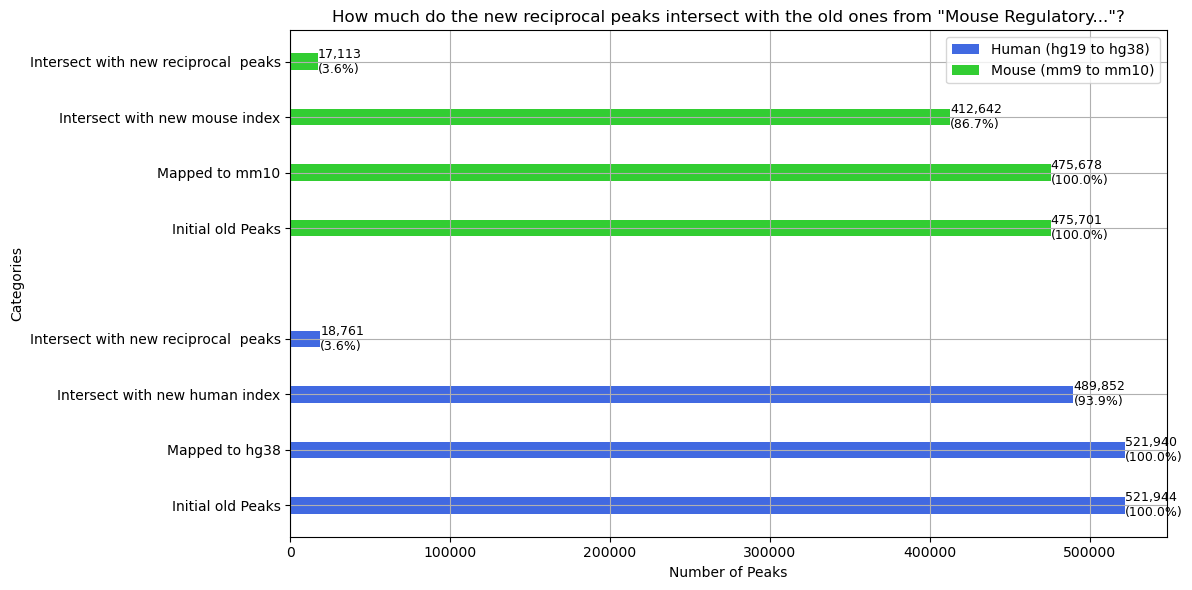

In [383]:
categories = ['Initial Peaks', 'Mapped to hg38', 'Intersect with New Index', 'Intersect with New Peaks']
human_data = [521944, 521940, 489852, 18761]
mouse_data = [475701, 475678, 412642, 17113]

# Function to calculate percentages
def calculate_percentages(data):
    base = data[0]
    return [x / base * 100 for x in data]

# Calculating percentages
human_percentages = calculate_percentages(human_data)
mouse_percentages = calculate_percentages(mouse_data)

# Position setup
human_pos = list(range(len(categories)))
mouse_pos = [x + len(categories) + 1 for x in range(len(categories))]

# Colors and bar width
human_color = 'royalblue'
mouse_color = 'limegreen'
tight_bar_width = 0.3

# Creating the horizontal plot
fig, ax = plt.subplots(figsize=(12, 6))
human_bars = ax.barh(human_pos, human_data, tight_bar_width, label='Human (hg19 to hg38)', color=human_color)
mouse_bars = ax.barh(mouse_pos, mouse_data, tight_bar_width, label='Mouse (mm9 to mm10)', color=mouse_color)

# Setting labels and titles
ax.set_ylabel('Categories')
ax.set_xlabel('Number of Peaks')
ax.set_title('How much do the new reciprocal peaks intersect with the old ones from "Mouse Regulatory..."?')
all_positions = human_pos + mouse_pos
labels = [
    "Initial old Peaks",
    "Mapped to hg38",
    "Intersect with new human index",
    "Intersect with new reciprocal  peaks",
    "Initial old Peaks",
    "Mapped to mm10",
    "Intersect with new mouse index",
    "Intersect with new reciprocal  peaks"
]  
ax.set_yticks(all_positions)
ax.set_yticklabels(labels)

# Adding percentage labels
for bars, percentages in zip((human_bars, mouse_bars), (human_percentages, mouse_percentages)):
    for bar, percentage in zip(bars, percentages):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{int(width):,}\n({percentage:.1f}%)',
                ha='left', va='center', fontsize=9)

ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


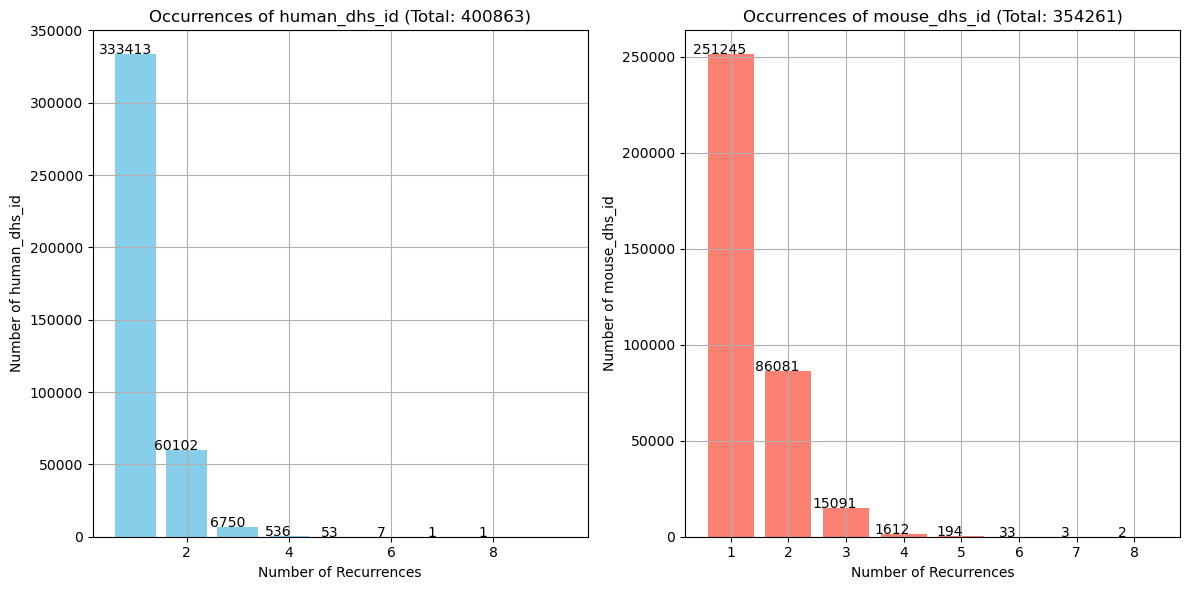

Total number of unique Human DHS IDs: 400863
Total number of unique Mouse DHS IDs: 354261


In [392]:
# Count occurrences of human_dhs_id and mouse_dhs_id
human_dhs_count = Counter(entry[0] for entry in reciprocal_entries)
mouse_dhs_count = Counter(entry[1] for entry in reciprocal_entries)

# Count the total number of unique human_dhs_id and mouse_dhs_id
total_human = len(human_dhs_count)
total_mouse = len(mouse_dhs_count)

# Count how many human_dhs_id are present in more than 1 entry
human_dhs_multiple_counts = Counter(human_dhs_count.values())
# Count how many mouse_dhs_id are present in more than 1 entry
mouse_dhs_multiple_counts = Counter(mouse_dhs_count.values())

# Plot the results for human_dhs_id
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(human_dhs_multiple_counts.keys(), human_dhs_multiple_counts.values(), color='skyblue')
plt.xlabel('Number of Recurrences')
plt.ylabel('Number of human_dhs_id')
plt.title('Occurrences of human_dhs_id (Total: {})'.format(total_human))
plt.grid(True)

# Add total number on the plot for human_dhs_id
for i, count in enumerate(human_dhs_multiple_counts.values()):
    plt.text(i + 0.8, count + 0.5, str(count), ha='center')

# Plot the results for mouse_dhs_id
plt.subplot(1, 2, 2)
plt.bar(mouse_dhs_multiple_counts.keys(), mouse_dhs_multiple_counts.values(), color='salmon')
plt.xlabel('Number of Recurrences')
plt.ylabel('Number of mouse_dhs_id')
plt.title('Occurrences of mouse_dhs_id (Total: {})'.format(total_mouse))
plt.grid(True)

# Add total number on the plot for mouse_dhs_id
for i, count in enumerate(mouse_dhs_multiple_counts.values()):
    plt.text(i + 0.8, count + 0.5, str(count), ha='center')

plt.tight_layout()
plt.show()

# Print the total count of unique human_dhs_id and mouse_dhs_id
print("Total number of unique Human DHS IDs:", total_human)
print("Total number of unique Mouse DHS IDs:", total_mouse)